# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Experiments

The experiments were conducted using multi-agent DDPG agents. There was no re-engineering necessary, except to be able to configure shared network models.

### 3.1 First Experiment

The first experiment was conducted using a fully connected architecture with 512/256 hidden neurons for both the actor and the critic.

This experiment did not accomplish the goal of the environment.

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

from rl.ddpg_agent import DDPGAgent
from rl.train import train
from rl.model import Actor, Critic
from utils.rnd import Seeds

seedGenerator = Seeds('seeds')
seedGenerator.next()
from rl.buffer import UniformReplayBuffer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

experience_params = {
    'seed': seedGenerator,       # seed for the experience replay buffer
    'buffer_size': 100000,        # size of the replay buffer
    'batch_size': 128            # batch size sampled from the replay buffer
}

experienceReplay = UniformReplayBuffer(experience_params)


# shared Actor/Critic Networks (w/ Target Network)
#actor_local = Actor(model_params['actor_params']).to(device)
#actor_target = Actor(model_params['actor_params']).to(device)
#actor_optimizer = optim.Adam(actor_local.parameters(), lr=model_params['actor_params']['lr'])

params = {
    'name': 'Tennis-512-256',
    'episodes': 5000,            # number of episodes
    'maxlen': 100,               # sliding window size of recent scores
    'brain_name': brain_name,    # the brain name of the unity environment
    'achievement': 0.5,           # score at which the environment is considered solved
    'environment': env,
    'agent_params': {
        'experience_replay': experienceReplay,
        'actor_local': None,
        'actor_target': None,
        'actor_optimizer': None,
        'critic_local': None,
        'critic_target': None,
        'critic_optimizer': None,
        'actor_params': {            # actor parameters
            'norm': True,
            'lr': 0.0001,                 # learning rate
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,       # seed of the network architecture
            'hidden_layers': [512, 256],  # hidden layer neurons
            'dropout': 0.05,
            'act_fn': [F.leaky_relu, F.leaky_relu, F.tanh]
        },
        'critic_params': {               # critic parameters
            'norm': True,
            'lr': 0.0001,                 # learning rate
            'weight_decay': 0.0,         # weight decay
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,       # seed of the network architecture
            'hidden_layers': [512, 256],  # hidden layer neurons
            'dropout': 0.05,
            'action_layer': 1,
            'act_fn': [F.leaky_relu, F.leaky_relu, lambda x: x]
        },
        'seed': seedGenerator,
        'num_agents': num_agents,    # number of agents in the environment
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'update_every': 5,          # update every n-th step
        'num_updates': 10,            # we don't necessarily need to run as many rounds of updates as there are agents
        'add_noise': True,           # add noise using 'noise_params'
        'noise_params': {            # parameters for the noisy process
            'mu': 0.,                # mean
            'theta': 0.15,           # theta value for the ornstein-uhlenbeck process
            'sigma': 0.2,            # variance
            'seed': seedGenerator,   # seed
            'action_size': action_size
        }
    }
}

agents = [DDPGAgent(idx=idx, params=params['agent_params']) for idx, a in enumerate(range(num_agents))]

scores = train(agents=agents, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'Tennis-512-256': scores})
df.to_csv('results/Tennis-512-256-scores.csv', index=False)

### 3.2 Second Experiment

Since we failed at the first experiment, there are a number of things we can try. Among those are to increase the number of episodes considerably to check whether any learning is attainable given the same architecture; or we could widen or deepen the neural network model.

Here, we use a larger batch size and run the experiment for much longer, i.e., 15000 episodes. The second experiment reaches the 0.5 goal of the environment.

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

from rl.ddpg_agent import DDPGAgent
from rl.train import train
from rl.model import Actor, Critic
from utils.rnd import Seeds

seedGenerator = Seeds('seeds')
seedGenerator.next()
from rl.buffer import UniformReplayBuffer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

experience_params = {
    'seed': seedGenerator,       # seed for the experience replay buffer
    'buffer_size': 10000,       # size of the replay buffer
    'batch_size': 512            # batch size sampled from the replay buffer
}

experienceReplay = UniformReplayBuffer(experience_params)


params = {
    'name': 'Tennis-512-256-2',
    'episodes': 15000,            # number of episodes
    'maxlen': 100,               # sliding window size of recent scores
    'brain_name': brain_name,    # the brain name of the unity environment
    'achievement': 0.5,          # score at which the environment is considered solved
    'environment': env,
    'agent_params': {
        'experience_replay': experienceReplay,
        'actor_local': None,
        'actor_target': None,
        'actor_optimizer': None,
        'critic_local': None,
        'critic_target': None,
        'critic_optimizer': None,
        'actor_params': {            # actor parameters
            'norm': True,
            'lr': 0.0001,                # learning rate
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,       # seed of the network architecture
            'hidden_layers': [512, 256],  # hidden layer neurons
            'dropout': 0.2,
            'act_fn': [F.leaky_relu, F.leaky_relu, F.tanh]
        },
        'critic_params': {               # critic parameters
            'norm': True,
            'lr': 0.0001,                # learning rate
            'weight_decay': 0.0,         # weight decay
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': seedGenerator,       # seed of the network architecture
            'hidden_layers': [512, 256],  # hidden layer neurons
            'dropout': 0.2,
            'action_layer': 1,
            'act_fn': [F.leaky_relu, F.leaky_relu, lambda x: x]
        },
        'seed': seedGenerator,
        'num_agents': num_agents,    # number of agents in the environment
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'update_every': 5,           # update every n-th step
        'num_updates': 10,           # we don't necessarily need to run as many rounds of updates as there are agents
        'add_noise': True,           # add noise using 'noise_params'
        'noise_params': {            # parameters for the noisy process
            'mu': 0.,                # mean
            'theta': 0.15,           # theta value for the ornstein-uhlenbeck process
            'sigma': 0.2,            # variance
            'seed': seedGenerator,   # seed
            'action_size': action_size
        }
    }
}

agents = [DDPGAgent(idx=idx, params=params['agent_params']) for idx, a in enumerate(range(num_agents))]

scores = train(agents=agents, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'Tennis-512-256-2': scores})
df.to_csv('results/Tennis-512-256-2-scores.csv', index=False)

DEBUG:matplotlib:$HOME=/Users/ddahlem
DEBUG:matplotlib:CONFIGDIR=/Users/ddahlem/.matplotlib
DEBUG:matplotlib:matplotlib data path: /Users/ddahlem/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /Users/ddahlem/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.0.0
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_darwin_darwin', '_osx_support', '

DEBUG:utils.rnd:Next random number seed: 904338947
DEBUG:rl.buffer:Parameter: {'seed': <utils.rnd.Seeds object at 0x11c0e4278>, 'buffer_size': 10000, 'batch_size': 512}
DEBUG:utils.rnd:Next random number seed: 291889961
DEBUG:rl.ddpg_agent:Parameter: {'experience_replay': <rl.buffer.UniformReplayBuffer object at 0x10f2d5b70>, 'actor_local': None, 'actor_target': None, 'actor_optimizer': None, 'critic_local': None, 'critic_target': None, 'critic_optimizer': None, 'actor_params': {'norm': True, 'lr': 0.0001, 'state_size': 24, 'action_size': 2, 'seed': <utils.rnd.Seeds object at 0x11c0e4278>, 'hidden_layers': [512, 256], 'dropout': 0.2, 'act_fn': [<function leaky_relu at 0x1207cc2f0>, <function leaky_relu at 0x1207cc2f0>, <function tanh at 0x1207cc8c8>]}, 'critic_params': {'norm': True, 'lr': 0.0001, 'weight_decay': 0.0, 'state_size': 24, 'action_size': 2, 'seed': <utils.rnd.Seeds object at 0x11c0e4278>, 'hidden_layers': [512, 256], 'dropout': 0.2, 'action_layer': 1, 'act_fn': [<function 

Episode 11018	Average Score: 0.52 	 Min: 0.00 	 Max: 2.60 	 Time: 75.736.54
Environment solved in 10918 episodes!	Average Score: 0.52 	 Time: 158365.36
Episode 11019	Average Score: 0.52 	 Min: 0.00 	 Max: 2.60 	 Time: 0.38
Environment solved in 10919 episodes!	Average Score: 0.52 	 Time: 158365.74
Episode 11020	Average Score: 0.52 	 Min: 0.00 	 Max: 2.60 	 Time: 8.46
Environment solved in 10920 episodes!	Average Score: 0.52 	 Time: 158374.20
Episode 11021	Average Score: 0.52 	 Min: 0.00 	 Max: 2.60 	 Time: 18.26
Environment solved in 10921 episodes!	Average Score: 0.52 	 Time: 158392.46
Episode 11022	Average Score: 0.52 	 Min: 0.00 	 Max: 2.60 	 Time: 4.99
Environment solved in 10922 episodes!	Average Score: 0.52 	 Time: 158397.46
Episode 11023	Average Score: 0.53 	 Min: 0.00 	 Max: 2.60 	 Time: 34.95
Environment solved in 10923 episodes!	Average Score: 0.53 	 Time: 158432.41
Episode 11024	Average Score: 0.56 	 Min: 0.00 	 Max: 2.60 	 Time: 76.71
Environment solved in 10924 episodes!	A

Episode 11074	Average Score: 0.64 	 Min: 0.00 	 Max: 2.60 	 Time: 3.84
Environment solved in 10974 episodes!	Average Score: 0.64 	 Time: 159096.40
Episode 11075	Average Score: 0.65 	 Min: 0.00 	 Max: 2.60 	 Time: 6.55
Environment solved in 10975 episodes!	Average Score: 0.65 	 Time: 159102.95
Episode 11076	Average Score: 0.64 	 Min: 0.00 	 Max: 2.60 	 Time: 4.17
Environment solved in 10976 episodes!	Average Score: 0.64 	 Time: 159107.12
Episode 11077	Average Score: 0.64 	 Min: 0.00 	 Max: 2.60 	 Time: 5.37
Environment solved in 10977 episodes!	Average Score: 0.64 	 Time: 159112.50
Episode 11078	Average Score: 0.64 	 Min: 0.00 	 Max: 2.60 	 Time: 3.46
Environment solved in 10978 episodes!	Average Score: 0.64 	 Time: 159115.96
Episode 11079	Average Score: 0.64 	 Min: 0.00 	 Max: 2.60 	 Time: 6.04
Environment solved in 10979 episodes!	Average Score: 0.64 	 Time: 159122.00
Episode 11080	Average Score: 0.63 	 Min: 0.00 	 Max: 2.60 	 Time: 5.98
Environment solved in 10980 episodes!	Average S

### 3.3 Third Experiment

We test whether a shared actor network helps in reducing the number of episodes to achieve the goal of the environment.

In [ ]:
env.close()

### 4. Summary

Here is a summary of the results obtained. We include the first experiment which was only run for 5000 episodes. The second experiment achieved the goal of the environment in under 11000 episodes. What is striking is that there was barely any improvement for nearly 5000 episodes before we experience a dramatic deterioration and a significant jump in performance, which peaked for a short time and degraded rapidly again. This irratic behaviour could be explained by the fact that one agent achieved superior performance compared to its opponent (i.e., winning 11000 to 4000 episodes).

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


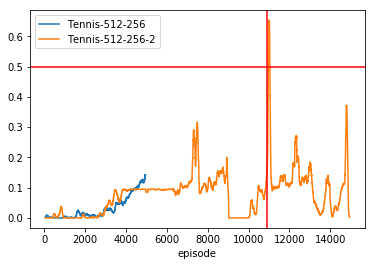

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd

achievementWindow = 100
df = pd.concat([pd.read_csv(f) for f in glob.glob('results/*-scores.csv')], axis=1)
df = df.loc[:,~df.columns.duplicated()]

dfRolling = df.rolling(achievementWindow).mean()
dfRolling.plot(x='episode', y=['Tennis-512-256', 'Tennis-512-256-2'], kind='line')
solvedAt = dfRolling[dfRolling['Tennis-512-256-2']>=0.5].index[0] - achievementWindow
plt.axvline(x=solvedAt, color='red')
plt.axhline(y=0.5, color='red')

The next plot shows the rewards obtained after every episode to demonstrate the maximum value attained during training (i.e., 2.6). Interestingly, this value was achieved a number of times in fairly narrow intervals before it degrated again.

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


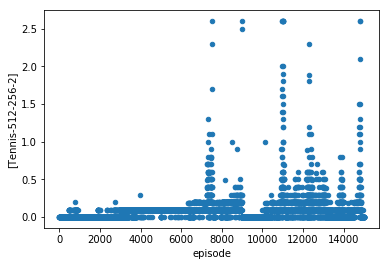

In [12]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('results/*-scores.csv')], axis=1)
df = df.loc[:,~df.columns.duplicated()]

df.plot(x='episode', y=['Tennis-512-256-2'], kind='scatter')

### 5. Future Work

While I accomodated for a shared actor model, this resulted in very poor performance as the actions appeared synchronized. Future work will look into this more carefully as I observed some stability expected issues during learning.